# PDHG ベースの SENSE + TV

mri.app.SenseRecon使用

SenseRecon: 100%|██████████| 50/50 [00:00<00:00, 50.86it/s, resid=7.76E-02]


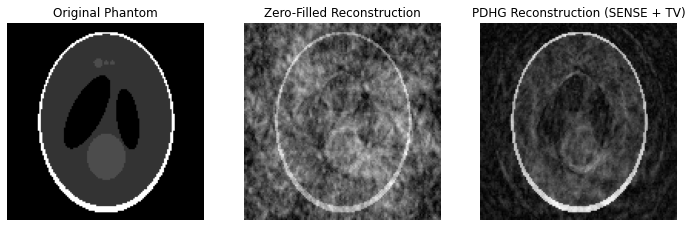

In [2]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction (Adjoint NUFFT)**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. Preconditioner を計算 (オプション)**
lamda = 0.01  # TV 正則化の強さ
p = mri.kspace_precond(mps, coord=coords)  # k-space Preconditioner

# **7. PDHG 法による SENSE + TV 再構成**
max_iter = 50  # 反復回数

sense_pdhg_app = mri.app.SenseRecon(
    ksp, mps, coord=coords, lamda=lamda, sigma=p, max_iter=max_iter,
    solver='PrimalDualHybridGradient'  # PDHG 法
)
reconstructed_img_pdhg = sense_pdhg_app.run()

# **8. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")  # 修正済み
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img_pdhg), cmap="gray")
axs[2].set_title("PDHG Reconstruction (SENSE + TV)")
axs[2].axis("off")

plt.show()


mr.app.TotalVariationRecon()使用

TotalVariationRecon: 100%|██████████| 50/50 [00:01<00:00, 39.13it/s, resid=2.62E-01]


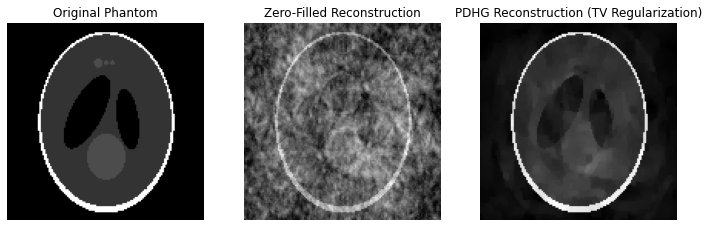

In [4]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction (Adjoint NUFFT)**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. Preconditioner の計算**
lamda = 0.01  # TV 正則化の強さ

# **G を用いた Preconditioner**
G = sp.linop.FiniteDifference(img_shape)  # TV の差分演算
max_eig_G = sp.app.MaxEig(G.H * G).run()

# **k-space Preconditioner の適用**
p = mri.kspace_precond(mps, coord=coords)  # k-space Preconditioner
sigma2 = np.ones([np.prod(img_shape) * len(img_shape)], dtype=ksp.dtype) / max_eig_G
sigma = np.concatenate([p.ravel(), sigma2.ravel()])

# **7. PDHG 法による SENSE + TV 再構成**
max_iter = 50  # 反復回数

tv_pdhg_app = mri.app.TotalVariationRecon(
    ksp, mps, lamda=lamda, coord=coords, sigma=sigma, max_iter=max_iter,
    solver='PrimalDualHybridGradient'  # PDHG 法
)
reconstructed_img_tv = tv_pdhg_app.run()

# **8. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")  # 修正済み
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img_tv), cmap="gray")
axs[2].set_title("PDHG Reconstruction (TV Regularization)")
axs[2].axis("off")

plt.show()


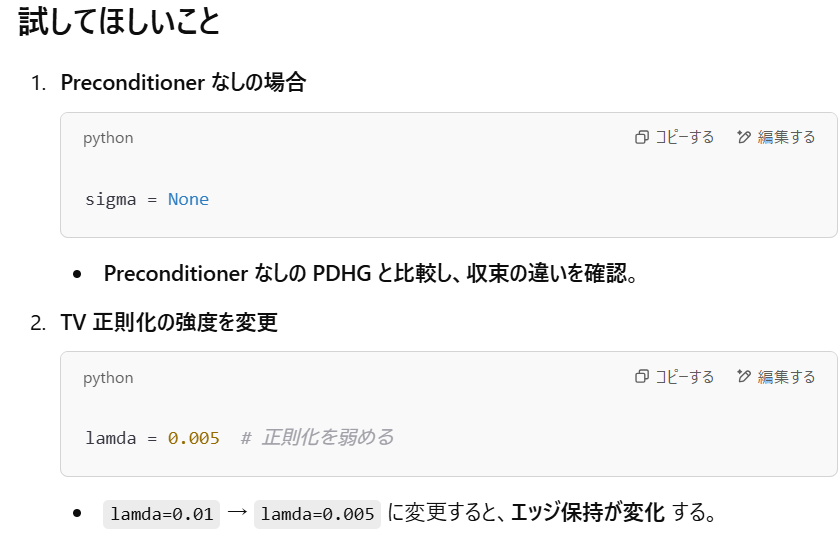